## Phase 3 : Prétraitement des données : Nettoyer et transformer les données pour préparer un jeu propre et utilisable. Identifier les données qui vous serviront à prédire l'éligibilité des clients aux crédits et qui ne sont pas à inclure dans les données d'entrainements et de test.

### Configuration

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

DATA_PATH = "../data/"
RAW_FILE = DATA_PATH + "raw/load_data.csv"
WITHOUT_MISSING_FILE = DATA_PATH + "processed/data_without_missing.csv"
FOR_TEST_FILE = DATA_PATH + "processed/data_for_test.csv"
PICKLE_PATH = "../outputs/pickle/"
ENCODER_FILE = PICKLE_PATH + "encoders_config.pkl"
FOR_TEST_FILE = DATA_PATH + "processed/data_for_test.csv"
CLEAN_FOR_TRAINING = DATA_PATH + "processed/data_clean_for_training.csv"

In [26]:
df = pd.read_csv(filepath_or_buffer=RAW_FILE, sep=",", header=0)

### Gestion des doublons

In [27]:
df[df.duplicated()]
df = df.drop_duplicates()

> Il n'y a pas de doublon dans ce dataset

### Gestion des valeurs manquantes

#### a. Vérification de colonne

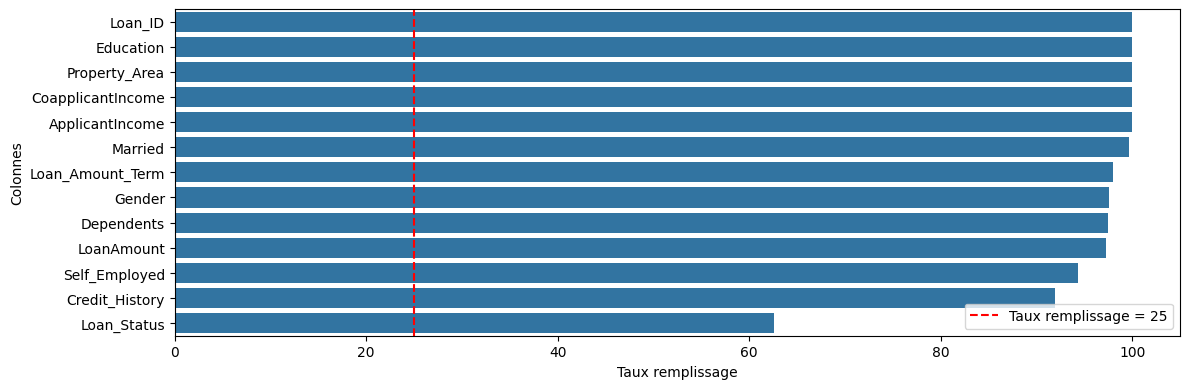

In [67]:
# Calculer le taux de remplissage pour chaque colonne
valeurs = df.notnull().mean() * 100
colonnes = df.columns.astype(str)
SEUIL_VALEURS_VIDES = 25
# Créer un DataFrame pour le taux de remplissage
df_remplissage = pd.DataFrame({'Colonnes': colonnes, 'Taux remplissage': valeurs.values})

# Trier le DataFrame par taux de remplissage
df_sorted = df_remplissage.sort_values(by='Taux remplissage', ascending=False).reset_index(drop=True)

# Créer le graphique
plt.figure(figsize=(12, 4))  # Taille de la figure
sns.barplot(x='Taux remplissage', y='Colonnes', data=df_sorted, orient='h')
plt.axvline(x=SEUIL_VALEURS_VIDES, color='red', linestyle='--', label=f'Taux remplissage = {SEUIL_VALEURS_VIDES}')

# Afficher la légende et le graphique
plt.legend()
plt.tight_layout()
plt.show()

> Il n'y a une nécéssité de supprimer une colonne selon un taux de remplissage

#### b. Vérification sur les lignes

In [68]:
df.isnull().sum()

Loan_ID                0
Gender                24
Married                3
Dependents            25
Education              0
Self_Employed         55
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount            27
Loan_Amount_Term      20
Credit_History        79
Property_Area          0
Loan_Status          367
dtype: int64

##### Imputation valeur faible (<5%)

In [46]:
# imputation car le nombre de valeur manquantes n'est pas énorme 
df_missing = df.copy()
df_missing["Gender"] = df_missing["Gender"].fillna(df_missing["Gender"].mode()[0])
df_missing["Married"] = df_missing["Married"].fillna(df_missing["Married"].mode()[0])
df_missing["Dependents"] = df_missing["Dependents"].fillna(df_missing["Dependents"].mode()[0])
df_missing["Loan_Amount_Term"] = df_missing["Loan_Amount_Term"].fillna(df_missing["Loan_Amount_Term"].mode()[0])
df_missing["LoanAmount"] = df_missing["LoanAmount"].fillna(df_missing["LoanAmount"].median())

##### Imputation valeur modérée (5% ~ 10%)

In [47]:
# imputation car le nombre de valeur manquante est modérée
df_missing["Self_Employed"] = df_missing["Self_Employed"].fillna("No")
df_missing["Credit_History"] = df_missing["Credit_History"].fillna(0)

##### Suppression valeur cible

In [48]:
df_missing = df_missing.dropna(subset=["Loan_Status"])
df_missing.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

##### Application des valeurs absentes dans le dataSet

In [28]:
# imputation car le nombre de valeur manquantes n'est pas énorme 
df["Gender"] = df["Gender"].fillna(df["Gender"].mode()[0])
df["Married"] = df["Married"].fillna(df["Married"].mode()[0])
df["Dependents"] = df["Dependents"].fillna(df["Dependents"].mode()[0])
df["Loan_Amount_Term"] = df["Loan_Amount_Term"].fillna(df["Loan_Amount_Term"].mode()[0])
df["LoanAmount"] = df["LoanAmount"].fillna(df["LoanAmount"].median())
# imputation car le nombre de valeur manquante est modérée
df["Self_Employed"] = df["Self_Employed"].fillna("No")
df["Self_Employed"] = df["Self_Employed"].fillna("No")
df["Credit_History"] = df["Credit_History"].fillna(0)
# On va garder les valeurs nan pour les futurs test
df_for_test = df[df["Loan_Status"].isnull()]
# suppression des valeurs null pour la valeur cible
df = df.dropna(subset=["Loan_Status"])

### Gestion des encodages

#### Analyse des colonnes catégory

In [29]:
df.describe(include=["O"])

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,614,614,614,614,614,614,614
unique,614,2,2,4,2,2,3,2
top,LP002990,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,502,401,360,480,532,233,422


#### Remplacement des catégorie binaire

In [30]:
from sklearn.preprocessing import LabelEncoder

##### a. Gender

In [52]:
le = LabelEncoder()
df_gender = df.copy()
df_gender["Gender_encoder"] = le.fit_transform(df_gender["Gender"])
df_gender[["Gender", "Gender_encoder"]].value_counts()

Gender  Gender_encoder
Male    1                 502
Female  0                 112
Name: count, dtype: int64

##### b. Married

In [53]:
le = LabelEncoder()
df_married = df.copy()
df_married["Married_encoder"] = le.fit_transform(df_married["Married"])
df_married[["Married", "Married_encoder"]].value_counts()

Married  Married_encoder
Yes      1                  401
No       0                  213
Name: count, dtype: int64

##### c. Education

In [54]:
le = LabelEncoder()
df_education = df.copy()
df_education["Education_encoder"] = le.fit_transform(df_education["Education"])
df_education[["Education", "Education_encoder"]].value_counts()

Education     Education_encoder
Graduate      0                    480
Not Graduate  1                    134
Name: count, dtype: int64

La valeur Education en encoder est inverser je vais utiliser un map

In [55]:
df_education = df.copy()
mapping = {"Graduate": 1, "Not Graduate": 0}
df_education["Education_encoder"] = df["Education"].map(mapping)
df_education[["Education", "Education_encoder"]].value_counts()

Education     Education_encoder
Graduate      1                    480
Not Graduate  0                    134
Name: count, dtype: int64

##### d. Self_Employed


In [70]:
le = LabelEncoder()
df_self_employed = df.copy()
df_self_employed["Self_Employed_encoder"] = le.fit_transform(df_self_employed["Self_Employed"])
df_self_employed[["Self_Employed", "Self_Employed_encoder"]].value_counts()

Self_Employed  Self_Employed_encoder
No             0                        532
Yes            1                         82
Name: count, dtype: int64

##### e. Loan_Status

In [56]:
le = LabelEncoder()
df_loan_status = df.copy()
df_loan_status["Loan_Status_encoder"] = le.fit_transform(df_loan_status["Loan_Status"])
df_loan_status[["Loan_Status", "Loan_Status_encoder"]].value_counts()

Loan_Status  Loan_Status_encoder
Y            1                      422
N            0                      192
Name: count, dtype: int64

#### Remplacement des catégorie multiclasse

##### a. Dependents

In [61]:
le = LabelEncoder()
df_self_employed = df.copy()
df_self_employed["Dependents_encoder"] = le.fit_transform(df_self_employed["Dependents"])
df_self_employed[["Dependents", "Dependents_encoder"]].value_counts()

Dependents  Dependents_encoder
0           0                     360
1           1                     102
2           2                     101
3+          3                      51
Name: count, dtype: int64

##### b. Property_Area
> Il n'y a pas d'ordre sur les valeurs "Semiurban", "Urban", "Rural". Le One Hot est préféré pour l'encodage


In [66]:
dummies = pd.get_dummies(df["Property_Area"], prefix="Property_Area")
encoded_df = pd.concat([df, dummies], axis=1).drop(columns=["Property_Area"])
encoded_df[[col for col in encoded_df.columns.to_list() if "Property_Area" in col]]

,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,False,False,True
1,True,False,False
2,False,False,True
3,False,False,True
4,False,False,True
...,...,...,...
609,True,False,False
610,True,False,False
611,False,False,True
612,False,False,True


##### Application de l'encodage

In [31]:
encoders_config = {}

for col in df.columns:
    if col == "Gender" or col == "Married" or col == "Self_Employed" or col == "Loan_Status" or col == "Dependents":
        # labelEncoder 
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders_config[col] = {"type": "LabelEncoder", "encoder": le}
    elif col == "Education":
        # Mapping manuel
        mapping = {"Graduate": 0, "Not Graduate": 1}
        df[col] = df[col].map(mapping)
        encoders_config[col] = {"type": "map", "mapping": mapping}
    elif col == "Property_Area":
        # One-Hot Encoding
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1).drop(columns=[col])
        encoders_config[col] = {"type": "get_dummies", "columns": dummies.columns.tolist()}


In [101]:
with open(ENCODER_FILE, "wb") as file:
    pickle.dump(encoders_config, file)

##### Enregistrement du dataset

In [32]:
df.to_csv(WITHOUT_MISSING_FILE, index=False)

df_for_test.to_csv(FOR_TEST_FILE, index=False)

### Gestion des valeurs aberrantes

#### Chargement du fichier sans valeur absente (OPTIONNEL)

In [33]:
df = pd.read_csv(filepath_or_buffer=WITHOUT_MISSING_FILE, sep=",", header=0)

In [73]:
# Liste des colonnes numériques
numeric_columns = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"] 

df[numeric_columns].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,145.680782,342.410423
std,6109.041673,2926.248369,84.123205,64.428629
min,150.000000,0.000000,9.000000,12.000000
25%,2877.500000,0.000000,100.250000,360.000000
50%,3812.500000,1188.500000,126.000000,360.000000
75%,5795.000000,2297.250000,164.750000,360.000000
max,81000.000000,41667.000000,700.000000,480.000000


##### Analyse des outliers avec un calcule du quantile

In [78]:
outliers_info = {}
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)  # 25e percentile
    Q3 = df[col].quantile(0.75)  # 75e percentile
    IQR = Q3 - Q1  # Étendue interquartile
    
    # Bornes inférieure et supérieure
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifier les outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_info[col] = {
        "outliers": outliers,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "num_outliers": len(outliers),
    }
    print(f"Colonne : {col}")
    print(f"  - Nombre d'outliers : {len(outliers)} ({(len(outliers)/len(df)) * 100:.2f}%)")
    print(f"  - Borne inférieure : {lower_bound}")
    print(f"  - Borne supérieure : {upper_bound}")
    print("\n")

Colonne : ApplicantIncome
  - Nombre d'outliers : 50 (8.14%)
  - Borne inférieure : -1498.75
  - Borne supérieure : 10171.25


Colonne : CoapplicantIncome
  - Nombre d'outliers : 18 (2.93%)
  - Borne inférieure : -3445.875
  - Borne supérieure : 5743.125


Colonne : LoanAmount
  - Nombre d'outliers : 41 (6.68%)
  - Borne inférieure : 3.5
  - Borne supérieure : 261.5


Colonne : Loan_Amount_Term
  - Nombre d'outliers : 88 (14.33%)
  - Borne inférieure : 360.0
  - Borne supérieure : 360.0




##### Traitement des outliers pour chaque colonne

In [81]:
df_clean = df.copy()

# ApplicantIncome : Capping et transformation logarithmique
Q1 = df_clean["ApplicantIncome"].quantile(0.25)
Q3 = df_clean["ApplicantIncome"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df_clean["ApplicantIncome"] = df_clean["ApplicantIncome"].clip(upper=upper_bound)
df_clean["ApplicantIncome_Log"] = np.log1p(df_clean["ApplicantIncome"])

# CoapplicantIncome : Capping et transformation logarithmique
Q1 = df_clean["CoapplicantIncome"].quantile(0.25)
Q3 = df_clean["CoapplicantIncome"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df_clean["CoapplicantIncome"] = df_clean["CoapplicantIncome"].clip(upper=upper_bound)
df_clean["CoapplicantIncome_Log"] = np.log1p(df_clean["CoapplicantIncome"])

# LoanAmount : Suppression des valeurs < 3.5, Capping, et transformation logarithmique
Q1 = df_clean["LoanAmount"].quantile(0.25)
Q3 = df_clean["LoanAmount"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df_clean[df_clean["LoanAmount"] >= lower_bound]
df_clean["LoanAmount"] = df_clean["LoanAmount"].clip(upper=upper_bound)
df_clean["LoanAmount_Log"] = np.log1p(df_clean["LoanAmount"])

# Loan_Amount_Term : Suppression des valeurs non égales à 360
df_clean = df_clean[df_clean["Loan_Amount_Term"] == 360.0]

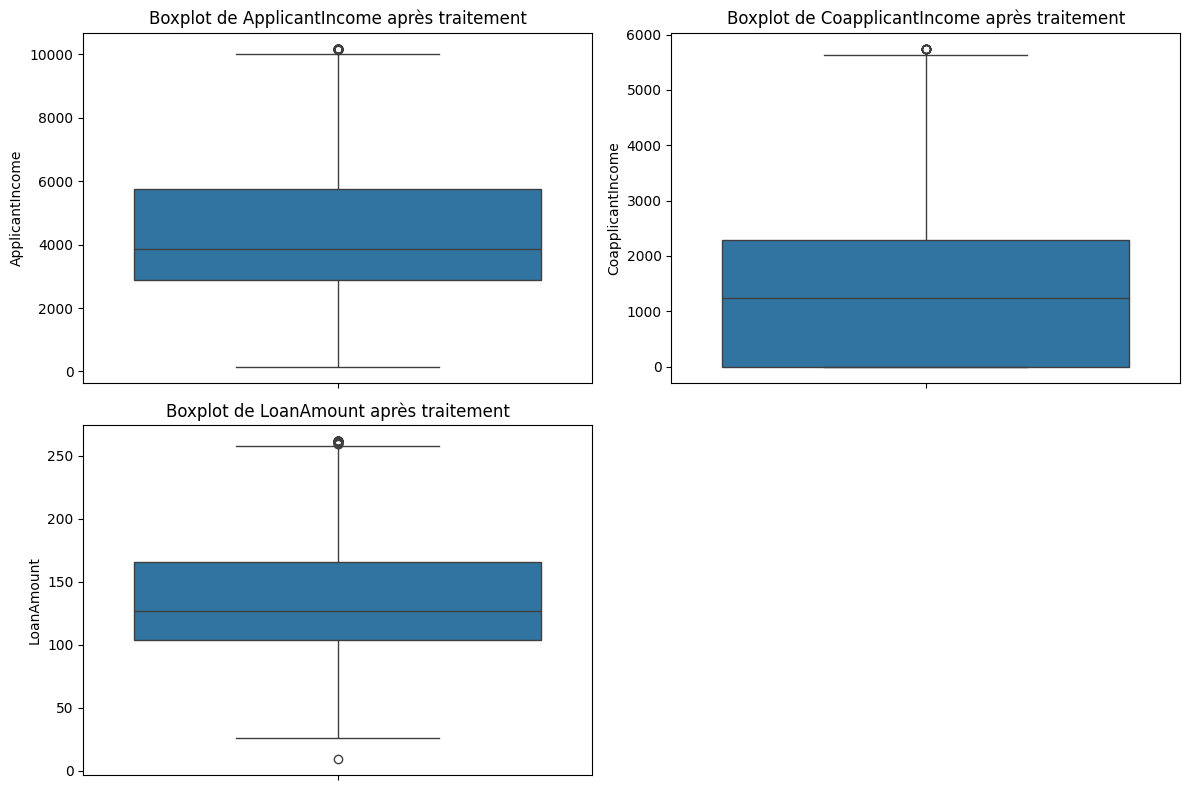

In [84]:
plt.figure(figsize=(12, 8))
numeric_columns = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]

for i, col in enumerate(numeric_columns):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df_clean, y=col)
    plt.title(f"Boxplot de {col} après traitement")
plt.tight_layout()
plt.show()

On remarque que pour LoanAmount les valeurs >250 sont bien plafonnées, mais il reste une valeur basse (<25) qui semble aberrante.

In [91]:
df_clean = df_clean[df_clean["LoanAmount"] >= 25]

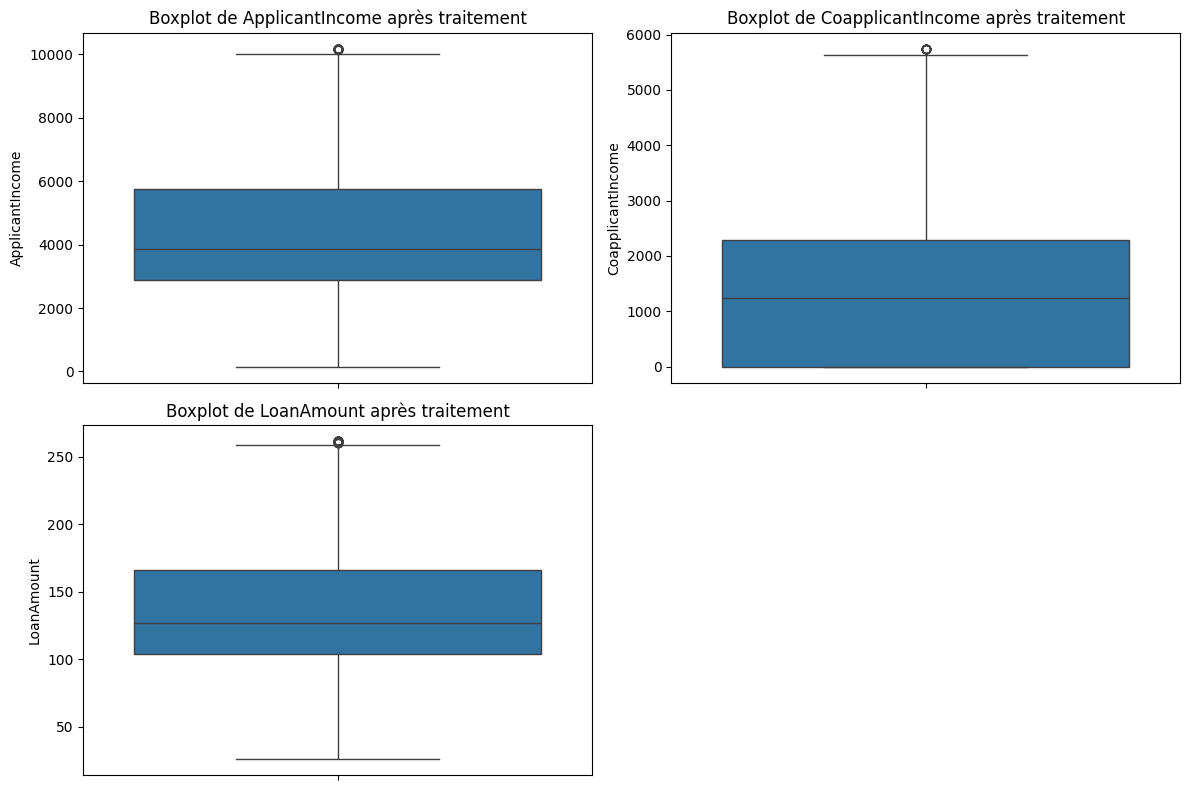

In [93]:
plt.figure(figsize=(12, 8))
numeric_columns = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]

for i, col in enumerate(numeric_columns):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df_clean, y=col)
    plt.title(f"Boxplot de {col} après traitement")
plt.tight_layout()
plt.show()

PARFAIT! Les valeurs aberrantes sont gérées

In [98]:
df_clean.to_csv(CLEAN_FOR_TRAINING, index=False)